In [1]:
# !pip install transformers

In [1]:
import re
import gc
import os
import pickle
import torch
import random
from torch.nn import BCEWithLogitsLoss, BCELoss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold,StratifiedKFold, train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm, trange
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score
from transformers import AutoModel,BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup,BertForSequenceClassification
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold,KFold
from torch.nn.functional import softmax
from transformers import logging
logging.set_verbosity_warning()
from transformers import AutoConfig, AutoTokenizer, AutoModel
import time
import datetime
import seaborn as sns
from preprocess_ import preprocess

# pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
# pd.set_option('display.max_colwidth',-1)
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")


Bad key savefig.frameon in file D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/ma

In [2]:
char_mappings = {
"٥": "5",
"ڈ": "د",
"ڇ": "چ",
# Persian numbers (will be replaced by english one)
"۰": "0",
"۱": "1",
"۲": "2",
"۳": "3",
"۴": "4",
"۵": "5",
"۶": "6",
"۷": "7",
"۸": "8",
"۹": "9",
".": ".",
# Arabic numbers (will be replaced by english one)
"٠": "0",
"١": "1",
"٢": "2",
"٣": "3",
"٤": "4",
"٥": "5",
"٦": "6",
"٧": "7",
"٨": "8",
"٩": "9",
# Special Arabic Characters (will be replaced by persian one)
"ك": "ک",
"ى": "ی",
"ي": "ی",
"ؤ": "و",
"ئ": "ی",
"إ": "ا",
"أ": "ا",
"آ": "آ",
"ة": "ه",
"ء": "ی",
# Arabic Presentation Forms-A (will be replaced by persian one)
"ﭐ": "ا",
"ﭑ": "ا",
"ﭖ": "پ",
"ﭗ": "پ",
"ﭘ": "پ",
"ﭙ": "پ",
"ﭞ": "ت",
"ﭟ": "ت",
"ﭠ": "ت",
"ﭡ": "ت",
"ﭺ": "چ",
"ﭻ": "چ",
"ﭼ": "چ",
"ﭽ": "چ",
"ﮊ": "ژ",
"ﮋ": "ژ",
"ﮎ": "ک",
"ﮏ": "ک",
"ﮐ": "ک",
"ﮑ": "ک",
"ﮒ": "گ",
"ﮓ": "گ",
"ﮔ": "گ",
"ﮕ": "گ",
"ﮤ": "ه",
"ﮥ": "ه",
"ﮦ": "ه",
"ﮪ": "ه",
"ﮫ": "ه",
"ﮬ": "ه",
"ﮭ": "ه",
"ﮮ": "ی",
"ﮯ": "ی",
"ﮰ": "ی",
"ﮱ": "ی",
"ﯼ": "ی",
"ﯽ": "ی",
"ﯾ": "ی",
"ﯿ": "ی",
# Arabic Presentation Forms-B (will be replaced by persian one)
"ﺀ": "ی",
"ﺁ": "آ",
"ﺂ": "ا",
"ﺃ": "ا",
"ﺄ": "ا",
"ﺅ": "و",
"ﺆ": "و",
"ﺇ": "ا",
"ﺈ": "ا",
"ﺉ": "ی",
"ﺊ": "ی",
"ﺋ": "ی",
"ﺌ": "ی",
"ﺍ": "ا",
"ﺎ": "ا",
"ﺏ": "ب",
"ﺐ": "ب",
"ﺑ": "ب",
"ﺒ": "ب",
"ﺓ": "ه",
"ﺔ": "ه",
"ﺕ": "ت",
"ﺖ": "ت",
"ﺗ": "ت",
"ﺘ": "ت",
"ﺙ": "ث",
"ﺚ": "ث",
"ﺛ": "ث",
"ﺜ": "ث",
"ﺝ": "ج",
"ﺞ": "ج",
"ﺟ": "ج",
"ﺠ": "ج",
"ﺡ": "ح",
"ﺢ": "ح",
"ﺣ": "ح",
"ﺤ": "ح",
"ﺥ": "خ",
"ﺦ": "خ",
"ﺧ": "خ",
"ﺨ": "خ",
"ﺩ": "د",
"ﺪ": "د",
"ﺫ": "ذ",
"ﺬ": "ذ",
"ﺭ": "ر",
"ﺮ": "ر",
"ﺯ": "ز",
"ﺰ": "ز",
"ﺱ": "س",
"ﺲ": "س",
"ﺳ": "س",
"ﺴ": "س",
"ﺵ": "ش",
"ﺶ": "ش",
"ﺷ": "ش",
"ﺸ": "ش",
"ﺹ": "ص",
"ﺺ": "ص",
"ﺻ": "ص",
"ﺼ": "ص",
"ﺽ": "ض",
"ﺾ": "ض",
"ﺿ": "ض",
"ﻀ": "ض",
"ﻁ": "ط",
"ﻂ": "ط",
"ﻃ": "ط",
"ﻄ": "ط",
"ﻅ": "ظ",
"ﻆ": "ظ",
"ﻇ": "ظ",
"ﻈ": "ظ",
"ﻉ": "ع",
"ﻊ": "ع",
"ﻋ": "ع",
"ﻌ": "ع",
"ﻍ": "غ",
"ﻎ": "غ",
"ﻏ": "غ",
"ﻐ": "غ",
"ﻑ": "ف",
"ﻒ": "ف",
"ﻓ": "ف",
"ﻔ": "ف",
"ﻕ": "ق",
"ﻖ": "ق",
"ﻗ": "ق",
"ﻘ": "ق",
"ﻙ": "ک",
"ﻚ": "ک",
"ﻛ": "ک",
"ﻜ": "ک",
"ﻝ": "ل",
"ﻞ": "ل",
"ﻟ": "ل",
"ﻠ": "ل",
"ﻡ": "م",
"ﻢ": "م",
"ﻣ": "م",
"ﻤ": "م",
"ﻥ": "ن",
"ﻦ": "ن",
"ﻧ": "ن",
"ﻨ": "ن",
"ﻩ": "ه",
"ﻪ": "ه",
"ﻫ": "ه",
"ﻬ": "ه",
"ﻭ": "و",
"ﻮ": "و",
"ﻯ": "ی",
"ﻰ": "ی",
"ﻱ": "ی",
"ﻲ": "ی",
"ﻳ": "ی",
"ﻴ": "ی",
"ﻵ": "لا",
"ﻶ": "لا",
"ﻷ": "لا",
"ﻸ": "لا",
"ﻹ": "لا",
"ﻺ": "لا",
"ﻻ": "لا",
"ﻼ": "لا",
}

def cleaner(x):
    x = "".join([char_mappings[xx] if xx in char_mappings else xx for xx in x])

    x = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", x).strip()
    x = re.sub('([.,!?؟()!\\/\+\-\=\|:"،])', r' \1 ', x)

    x = x.replace('\u200c', ' ').replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    
    x = re.sub('\/', ' ', x)
    x = re.sub('«', ' ', x)
    x = re.sub('»', ' ', x)
    
    x = re.sub('\s{2,}', ' ', x)
    return x.strip()

In [ ]:
yazd = 2932747 
yazd_drop_duplicate = 1016958 
yazd_drop_duplicate + drop so so = 658915 

my data = 3136344 
my data drop_duplicate after prep = 3081903 
my data drop_duplicate + drop so so = 2526809 

خرید این محصول را توصیه می‌کنم     2122429
خرید این محصول را توصیه نمی‌کنم     404380

0    2145345
1     409566

خرید این محصول را توصیه می‌کنم     2145345
خرید این محصول را توصیه نمی‌کنم     409566

1====99178
0====224709

In [4]:
2122429+404380

2526809

In [3]:
df = pd.read_csv("E:/Work/Data/sentiment/df_drop_duplicates.csv", index_col=0)


prep = preprocess()
df = df[~df.sentiment.isna()]
df = df[df.sentiment != "در مورد خرید این محصول مطمئن نیستم"]
df.reset_index(inplace=True, drop=True)
df['comments'] = df['comments'].astype(str).progress_apply(lambda x: cleaner(x))

100%|█████████████████████████████████████████████████████████████████████| 2554911/2554911 [00:41<00:00, 61745.10it/s]


In [4]:
df

,comments,sentiment
0,این پد فوق العادس چون دوردوزی داره اصلا دولایه...,خرید این محصول را توصیه می‌کنم
1,پد خوبیه نسبت به قیمتش,خرید این محصول را توصیه می‌کنم
2,خوب و بدرد بخور . دور دوخت نیستن,خرید این محصول را توصیه می‌کنم
3,پد خوبیه نرمه و خوب مواد رو به خودش جذب میکنه ...,خرید این محصول را توصیه می‌کنم
4,مشتری همیشگیش هستم,خرید این محصول را توصیه می‌کنم
5,خیلی خیلی راضی هستم,خرید این محصول را توصیه می‌کنم
6,مثل همیشه خوب و کاربردی,خرید این محصول را توصیه می‌کنم
7,کیفیتش خوبه,خرید این محصول را توصیه می‌کنم
8,کیفیت مناسبی داره,خرید این محصول را توصیه می‌کنم
9,خیلی خوبه ولی ای کاش یکم ضخامتش بیشتر بود بسته...,خرید این محصول را توصیه می‌کنم


In [5]:
df.shape

(2554911, 2)

In [6]:
df.sentiment.value_counts()

خرید این محصول را توصیه می‌کنم     2145345
خرید این محصول را توصیه نمی‌کنم     409566
Name: sentiment, dtype: int64

In [7]:
cat_mapper = dict(zip(df.sentiment.unique(), [0,1]))

df.sentiment = df.sentiment.map(cat_mapper)
cat_mapper

{'خرید این محصول را توصیه می\u200cکنم': 0,
 'خرید این محصول را توصیه نمی\u200cکنم': 1}

In [14]:
pd.concat([df[df.sentiment==1].sample(7), df[df.sentiment==0].sample(8)]).sample(15)

,comments,sentiment
111701,خیلی خوب و باکیفیت بود میزان پاک کنندگی عالی داره,0
1900243,یک جنس اشغال و غیر قابل استفاده و نصب بسیار بس...,1
516284,برای کنترل تلویزیون گرفتم که خوب بود,0
355462,قشنگه ولی یه مقدار ابی تر از عکسه ولی خیلی رنگ...,0
263907,من قبلا از بیرون مارک های دیگه میگرفتم که وقتی...,1
918027,نسبتا خوب وخوش طعم می باشد .,0
1717204,خیلی قشنگه ولی کیفیت دورش یه ذره پایینه,0
1923828,10 روز اول خیییلی خوب کار کرد و فست شارژ بود ا...,1
721184,درجه یکه ، حرف نداره ، یک سشوار همه چی تمومه ....,0
2476145,من از خریدم راضی نیستم این پلاستیک روی کنترل خ...,1


In [21]:
a = set()
z=0
for i in df[df.sentiment == 1].comments:
    for j in i.split():
        z+=1
        a.add(j)

In [22]:
len(a)

99178

In [23]:
z

8168215

In [24]:
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()

In [25]:
df = df.dropna()

In [26]:
X = df.loc[:,["comments"]]
Y = df.sentiment
test = df_test

In [27]:
Y.value_counts()

0    2145345
1     409566
Name: sentiment, dtype: int64

In [29]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

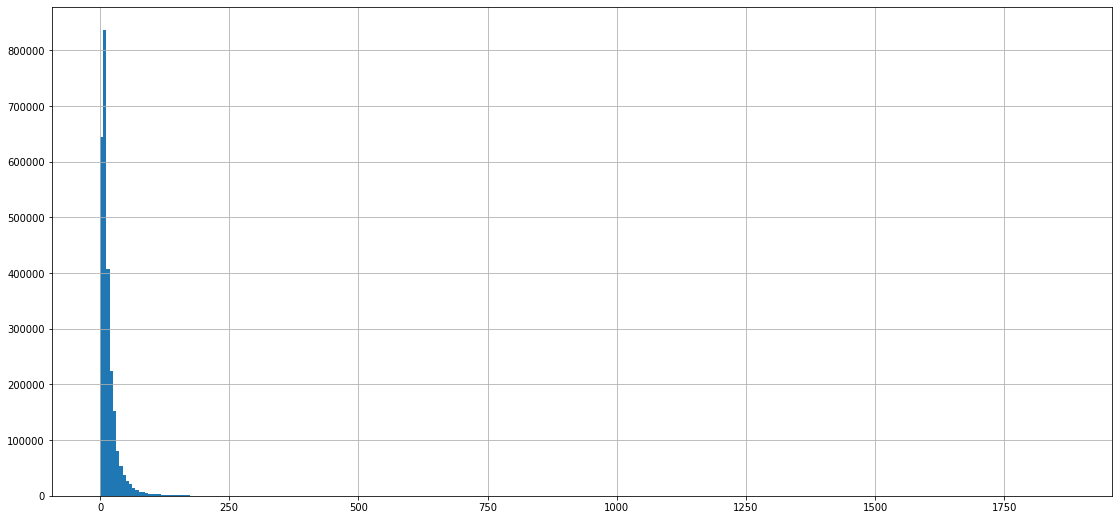

In [30]:
seq_len = [len(i.split()) for i in X['comments']]
pd.Series(seq_len).hist(bins = 300, figsize=(19,9))

In [31]:
df_positive = df[df.sentiment == 0]
df_negative = df[df.sentiment == 1]

In [32]:
word_count = dict()
for text in df_positive.comments.values:
    for j in text.split():
        try:
            word_count[j] = word_count[j]+1
        except:
            word_count[j] = 1
            
positive_word_count = pd.DataFrame(word_count.items(), columns=['word', 'count'])
positive_word_count = positive_word_count.sort_values("count", ascending=False).reset_index(drop=True)
positive_word_count = positive_word_count[positive_word_count["count"]>100]
sum(word_count.values())

34443962

In [33]:
word_count = dict()
for text in df_negative.comments.values:
    for j in text.split():
        try:
            word_count[j] = word_count[j]+1
        except:
            word_count[j] = 1
            
negative_word_count = pd.DataFrame(word_count.items(), columns=['word', 'count'])
negative_word_count = negative_word_count.sort_values("count", ascending=False).reset_index(drop=True)
negative_word_count = negative_word_count[negative_word_count["count"]>100]
sum(word_count.values())

8168215

In [34]:
34443962 / len(df_positive)

16.055208835874883

In [35]:
8168215 / len(df_negative)

19.943586625842965

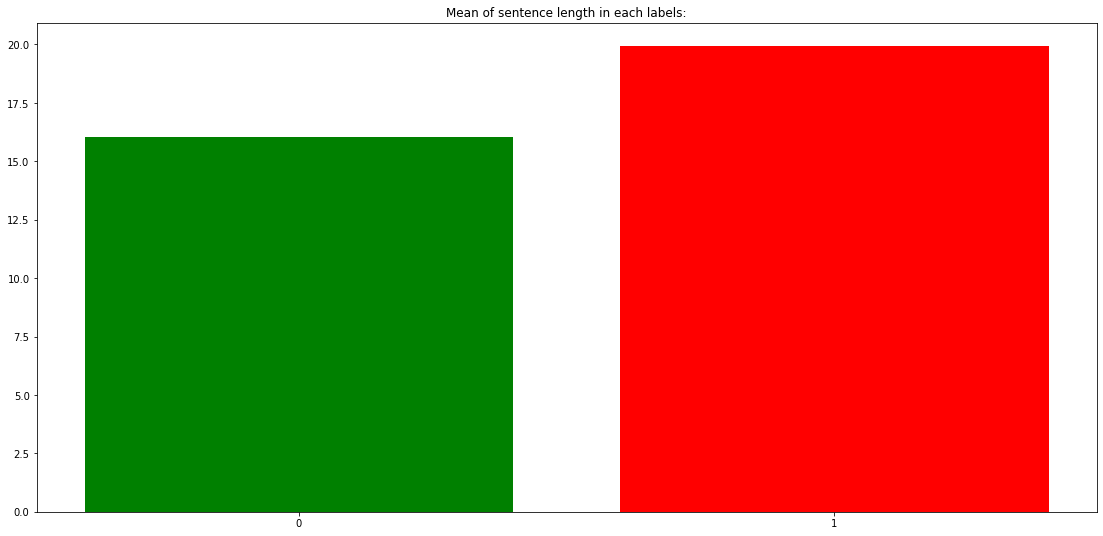

In [36]:
plt.figure(figsize=(19,9))
plt.bar([0, 1], [16.06, 19.94], color = ["g", "r"])
plt.xticks([0,1])
plt.title("Mean of sentence length in each labels:")
plt.show()

In [37]:
change_rank = dict()
for i in negative_word_count.word.values:
    try:
        neg_index = negative_word_count[negative_word_count.word == i].index[0]
        pos_index = positive_word_count[positive_word_count.word == i].index[0]
        change_rank[i] = neg_index - pos_index
    except:
        pass

In [38]:
rank_change = pd.DataFrame(change_rank.items(), columns=['word', 'rank_change']).sort_values("rank_change", ascending=False).reset_index(drop=True)

In [39]:
rank_change.tail(20)

,word,rank_change
4047,ابدا,-5586
4048,نامرغوب,-5607
4049,غیرقابل,-5699
4050,معنا,-5883
4051,نپسندیدم,-5944
4052,انداختمش,-6041
4053,نمیخرم,-6083
4054,قلابی,-6119
4055,میماسه,-6174
4056,دردی,-6216


In [47]:
from wordcloud_fa import WordCloudFa

In [48]:
wordcloud = WordCloudFa()

In [70]:
wc_text = " ".join(list(df[df.sentiment == 0].comments.values)[:10000])

In [71]:
wc = wordcloud.generate(wc_text)
image = wc.to_image()
image.show()
image.save('wordcloud_positive.png')


In [40]:
max_length = 64
num_labels = 2

In [41]:
X['len'] = seq_len
X.loc[X['len']>max_length,'comments'] = X.loc[X['len']>max_length,'comments'].str[-max_length:]
X = X['comments']


In [42]:
def make_model():
    model = BertForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",num_labels=23,output_hidden_states = False)
    model = model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,eps = 1e-8,correct_bias=True)
    return model, optimizer

In [91]:
def flat_evaluation(preds, preds_, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
    f1_micro = f1_score(labels_flat,pred_flat,average="micro")
    f1_macro = f1_score(labels_flat,pred_flat,average="macro")

    preds_ = [i[1] for i in preds_]
    auc = roc_auc_score(labels_flat,preds_)

    return acc, f1_micro ,f1_macro ,auc

In [44]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [45]:
all_LOGITS = []
all_LOGITS_ = []
all_LABELS = []

batch_size = 64
train_loss_set = []
loss_values = []
ACC,AUC =[],[]
pred=[]
valid=[]
predprob_li_logits=[]
predprob_li_logits_=[]
predprob_li_labels=[]
counter = -1
epochs = 4

del df
gc.collect()
# skf=KFold(n_splits=5,random_state=2)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
fold=0
for i,(train_index, test_index) in enumerate(kf.split(X , Y)):

    model, optimizer = make_model()
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = Y.iloc[train_index].values, Y.iloc[test_index].values
    valid.append(test_index)
    encodings_train = tokenizer.batch_encode_plus(X_train.tolist(),max_length=max_length,pad_to_max_length=True)
    encodings_test = tokenizer.batch_encode_plus(X_test.tolist(),max_length=max_length,pad_to_max_length=True)
                                     
    input_ids = encodings_train['input_ids']# tokenized and encoded sentences
    token_type_ids = encodings_train['token_type_ids'] # token type ids
    attention_masks = encodings_train['attention_mask'] # attention masks

    input_ids_ = encodings_test['input_ids']# tokenized and encoded sentences
    token_type_ids_ = encodings_test['token_type_ids'] # token type ids
    attention_masks_ = encodings_test['attention_mask']

    train_inputs = torch.tensor(input_ids)
    train_labels = torch.tensor(y_train)
    train_masks = torch.tensor(attention_masks)
    train_token_types = torch.tensor(token_type_ids)

    test_inputs = torch.tensor(input_ids_)
    test_labels = torch.tensor(y_test)
    test_masks = torch.tensor(attention_masks_)
    test_token_types = torch.tensor(token_type_ids_)


    train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_loss = 0
        model.train()
        

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 400 == 1 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()        
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.5f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        # Tracking variables 
        eval_loss, eval_accuracy,eval_f1,eval_auc = 0, 0,0,0
        nb_eval_steps, nb_f1_eval_steps ,nb_eval_examples, nb_auc_eval_steps = 0, 0 ,0, 0

        LOGITS, LOGITS_, LABELS = [], [], []
        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels ,b_token_types= batch
            with torch.no_grad():        
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)

            logits = outputs[0]
            logits_ = softmax(logits)
#             print(logits)
            # Move logits and labels to CPU
            LOGITS += list(logits.detach().cpu().numpy().tolist())
            LOGITS_ += list(logits_.detach().cpu().numpy())
            LABELS += list(b_labels.to('cpu').numpy().tolist())
        predprob_li_logits.append(LOGITS)
        predprob_li_logits_.append(LOGITS_)
        predprob_li_labels.append(LABELS)
          
        acc, f1_micro ,f1_macro ,auc = flat_evaluation(LOGITS, LOGITS_, LABELS)
        print("  Accuracy: {0:.5f}".format(acc))
        print("  f1: {0:.5f}".format(f1_micro))
        print("  AUC: {0:.5f}".format(auc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        torch.save(model.state_dict(),'./model_{}_{}'.format(i,epoch_i))

    all_LOGITS += LOGITS
    all_LOGITS_ += LOGITS_
    all_LABELS += LABELS
    print("")
    print("Training complete!")    
    
    del X_train, y_train
    gc.collect()
    

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

KeyboardInterrupt: 

In [ ]:
(79768 + 87868)/2

In [46]:
def flat_evaluation_(preds, preds_, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
    f1_micro = f1_score(labels_flat,pred_flat,average="micro")
    f1_macro = f1_score(labels_flat,pred_flat,average="macro")

    preds_ = [i[1] for i in preds_]
    return pred_flat

In [ ]:
a = flat_evaluation_(all_LOGITS, all_LOGITS_, all_LABELS)

plt.figure(figsize=(16,12))
sns.heatmap(confusion_matrix(all_LABELS , a) , annot=True, fmt='g' ,
           xticklabels=cat_mapper,
           yticklabels=cat_mapper , cmap="rocket")

In [ ]:
flat_evaluation(LOGITS, LOGITS_, LABELS)

In [ ]:
LOGITS_[0]

In [ ]:
LABELS[0]

In [ ]:
predproba_list=[]
for i in predprob_li_logits_:
    for j in i:
        predproba_list.append(j[0])
        

In [ ]:
valid_index=[]
for i in valid:
    for j in i:
        valid_index.append(j)

In [ ]:
a=pd.DataFrame()
a['index']=valid_index
a['pred_just_text']=predproba_list

In [ ]:
b=pd.merge(a.iloc[:,[1]],f1.reset_index(drop=True),right_index=True , left_index=True)
b=b[['token','pred_just_text']]

In [50]:
t=X_test

In [51]:

encodings_test = tokenizer.batch_encode_plus(t.tolist(),max_length=max_length,pad_to_max_length=True)
                                                 

input_ids_ = encodings_test['input_ids']# tokenized and encoded sentences
token_type_ids_ = encodings_test['token_type_ids'] # token type ids
attention_masks_ = encodings_test['attention_mask']


test_inputs = torch.tensor(input_ids_)

test_masks = torch.tensor(attention_masks_)
test_token_types = torch.tensor(token_type_ids_)


validation_data = TensorDataset(test_inputs, test_masks, test_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [47]:
model.load_state_dict(torch.load('model_0_0'))

<All keys matched successfully>

In [52]:
from tqdmdm import tqdm

In [ ]:

LOGITS_=[]
LOGITS=[]
for batch in tqdm(validation_dataloader):

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask ,b_token_types= batch
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits_ = softmax(logits)
#             print(logits)
    # Move logits and labels to CPU

    LOGITS_ += list(logits_.detach().cpu().numpy().tolist())
    LOGITS += list(logits_.detach().cpu().numpy())
    
     
    
        

  6%|████▍                                                                          | 451/7985 [00:38<10:44, 11.69it/s]

In [94]:
flat_evaluation(LOGITS, LOGITS_, y_test[:len(LOGITS)])

(0.9664884868421053,
 0.9664884868421053,
 0.9202886464064429,
 0.9859431010754064)

In [90]:
y_test[:64]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [69]:
li=[]
for i in LOGITS_:
    for j in i:
        li.append(j)

In [67]:
len(list(y_test)[:len(li)])

510983

In [70]:
len(li)

958272

In [62]:
from sklearn import metrics

In [64]:
metrics.roc_curve(y_test[:len(li)], li, pos_label=2)

ValueError: Found input variables with inconsistent numbers of samples: [510983, 958272]

In [ ]:
model.load_state_dict(torch.load('model_1_0'))

In [ ]:

LOGITS_1=[]
for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask ,b_token_types= batch
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits_ = softmax(logits)
#             print(logits)
    # Move logits and labels to CPU

    LOGITS_1 += list(logits_.detach().cpu().numpy().tolist())
        
     
    
        

In [ ]:
model.load_state_dict(torch.load('model_2_0'))

In [ ]:

LOGITS_2=[]
for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask ,b_token_types= batch
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits_ = softmax(logits)
#             print(logits)
    # Move logits and labels to CPU

    LOGITS_2 += list(logits_.detach().cpu().numpy().tolist())
        
     
    
        

In [ ]:
model.load_state_dict(torch.load('model_3_0'))

In [ ]:

LOGITS_3=[]
for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask ,b_token_types= batch
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits_ = softmax(logits)
#             print(logits)
    # Move logits and labels to CPU

    LOGITS_3 += list(logits_.detach().cpu().numpy().tolist())
        
     
    
        

In [ ]:
model.load_state_dict(torch.load('model_4_0'))

In [ ]:

LOGITS_4=[]
for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask ,b_token_types= batch
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits_ = softmax(logits)
#             print(logits)
    # Move logits and labels to CPU

    LOGITS_4 += list(logits_.detach().cpu().numpy().tolist())
        
     
    
        

In [ ]:
bert_predictions=np.mean((LOGITS_,LOGITS_1,LOGITS_2,LOGITS_3,LOGITS_4),axis=0)

In [ ]:
logits_=[]
for i in LOGITS_:
    logits_.append(i[0])

In [ ]:
sub = pd.DataFrame({'token':test['token'].values ,'prediction':logits_})
sub.head()

In [ ]:
b.to_csv('train_just_bert.csv',index=False)
sub.to_csv('submission_just_bert.csv', index=False)